In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [3]:
def zero_pad(X,pad):
    X_pad=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant')
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


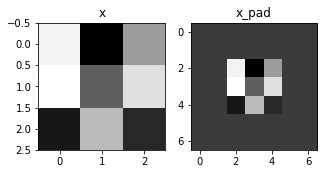

In [4]:
np.random.seed(1)
x=np.random.randn(4,3,3,2)
x_pad=zero_pad(x,2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [5]:
def conv_single_step(a_slice_prev,W,b):
    s=a_slice_prev*W   # *运算是对应位置相乘，dot是点乘，multiply是对应位置相乘
    #W相当于滤波器矩阵，a_slice_prev是被卷积的那部分像素块
    Z=np.sum(s)
    Z=Z+b
    return Z

np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = [[[-6.99908945]]]


In [6]:
def conv_forward(A_prev,W,b,hparameters):
    #获取被卷积区域的shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    #获取滤波器的shape
    (f, f, n_C_prev, n_C) = W.shape
    #从字典获取超参数
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    #计算卷积输出的shape尺寸，后面会用assert进行比对以确保正确
    n_H = int((n_H_prev - f + 2*pad) / stride + 1)
    n_W = int((n_W_prev - f + 2*pad) / stride + 1)
    #初始化卷积输出
    Z=np.zeros((m,n_H,n_W,n_C))
    #填充卷积边界区域
    A_prev_pad=zero_pad(A_prev,pad)
    
    #循环
    for i in range(m):
        #选择卷积的样本
        a_prev_pad=A_prev_pad[i,:,:,:]
        for h in range(n_H):  #纵向移动
            for w in range(n_W): #横向移动
                for c in range(n_C): #通道移动
                    #定位滤波器的四个角
                    vert_start=stride*h
                    vert_end=vert_start+f #f是滤波器的shape
                    horiz_start=stride*w
                    horiz_end=horiz_start+f
                    
                    #提取出当前滤波器覆盖的矩阵区域
                    a_slide_prev=a_prev_pad[vert_start:vert_end,horiz_start:horiz_end]
                    
                    #对提取区域实现滤波器卷积操作
                    Z[i,h,w,c]=conv_single_step(a_slide_prev,W[:,:,:,c],b[:,:,:,c])
                    
    assert(Z.shape==(m,n_H,n_W,n_C))

    #存储相关参数用于反向传播
    cache=(A_prev,W,b,hparameters)
    
    return Z,cache
                    

In [7]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [8]:
#实现池化层操作
def pool_forward(A_prev,hparameters,mode='max'):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    #提取池化操作的参数
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    #定义输出的理论维度:池化层不改变输出的通道数
    n_H=int(1+(n_H_prev-f)/stride)
    n_W=int(1+(n_W_prev-f)/stride)
    n_C=n_C_prev
    
    #初始化输出矩阵
    A=np.zeros((m,n_H,n_W,n_C))
    
    #循环操作
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    #定位池化框的四个角
                    vert_start=h*stride
                    vert_end=vert_start+f;
                    horiz_start=w*stride
                    horiz_end=horiz_start+f
                    
                    #获取吃画框当前位置对应的待池化矩阵
                    a_prev_slice=A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    #根据相应模式进行池化操作
                    if mode=='max':
                        A[i,h,w,c]=np.max(a_prev_slice)
                    elif mode=='average':
                        A[i,h,w,c]=np.mean(a_prev_slice)
    cache=(A_prev,hparameters)
    
    assert(A.shape==(m,n_H,n_W,n_C))
    
    return A,cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


In [10]:
##tensorflow模型
import math
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [12]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


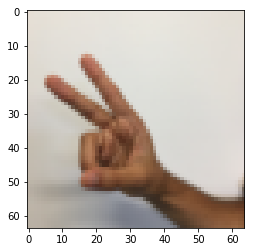

In [13]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [14]:
X_train_orig.shape

(1080, 64, 64, 3)

In [15]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X=tf.placeholder(tf.float32,shape=[None,n_H0,n_W0,n_C0])
    Y=tf.placeholder(tf.float32,shape=[None,n_y])
    
    return X,Y

In [16]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [57]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1=tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters={"W1":W1/np.sqrt(2),
               "W2":W2/np.sqrt(2)}
    
    return parameters

In [58]:
#初始化参数
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters=initialize_parameters()
    init=tf.global_variables_initializer()
    sess_test.run(init)
    print("W1="+str(parameters["W1"].eval()[1,1,1]))
    print("W2="+str(parameters["W2"].eval()[1,1,1]))

W1=[ 0.00093142  0.10024045 -0.03135985  0.06503491  0.10595348 -0.02485052
 -0.04841887  0.03708911]
W2=[-0.0605737   0.12551816  0.08467053  0.11860831 -0.05875654 -0.05697866
 -0.00408024 -0.10354756  0.17085207 -0.04141813 -0.13473934  0.09512198
 -0.1610764  -0.11326598 -0.11396781 -0.07273652]


In [59]:
def forward_propagation(X,parameters):
    W1=parameters['W1']
    W2=parameters['W2']
    
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    
    A2=tf.nn.relu(Z2)
    
    P2=tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    P2=tf.contrib.layers.flatten(P2)
    
    Z3=tf.contrib.layers.fully_connected(P2,6,activation_fn=None)
    
    return Z3

In [60]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X,Y=create_placeholders(64,64,3,6)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    init=tf.global_variables_initializer()
    sess.run(init)
    a=sess.run(Z3,{X:np.random.randn(2,64,64,3),Y:np.random.randn(2,6)})
    print("Z3="+str(a))

Z3=[[ 0.63031745 -0.9877705  -0.4421346   0.05680432  0.5849418   0.12013616]
 [ 0.43707377 -1.0388098  -0.5433439   0.0261174   0.57343066  0.02666192]]


In [25]:
#计算损失代价
def compute_cost(Z3,Y):
    #logits表示取对数概率，labels是行标签列表
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3,labels=Y))
    return cost

In [47]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X,Y=create_placeholders(64,64,3,6)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters) #前向传播函数，包含了“conv-relu-max_pool-conv-relu-max_pool-flatten-fully_connected-soft_max”的全过程
    cost=compute_cost(Z3,Y)
    init=tf.global_variables_initializer()
    sess.run(init)
    a=sess.run(cost,{X:np.random.randn(4,64,64,3),Y:np.random.randn(4,6)})
    print("cost="+str(a))

cost=4.66487


In [42]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,
         num_epochs=100,minibatch_size=64,print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]  #类别维度
    costs=[]
    
    X,Y=create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    
    cost=compute_cost(Z3,Y)
    
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init=tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            minibatch_cost=0.   #用于记录每代的总代价
            num_minibatches=int(m/minibatch_size)
            #每训练一代，seed+1
            seed=seed+1
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                
                #选择一个minibatch
                (minibatch_X,minibatch_Y)=minibatch
                
                #fetches参数指定要用sess进行的操作
                _,temp_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost+=temp_cost/num_minibatches
                
            if print_cost==True and epoch%5==0:
                print("cost after epoch %i:%f"%(epoch,minibatch_cost))
            if(print_cost==True and epoch%1==0):
                costs.append(minibatch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations(per tens)')
        plt.title('Learning rate='+str(learning_rate))
        plt.show()
        
        #计算正确的预测
        predict_op=tf.argmax(Z3,1)
        correct_prediction=tf.equal(predict_op,tf.argmax(Y,1))
        
        #在测试集上计算精度
        #reduce_mean:求和
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,'float'))
        print(accuracy)
        train_accuracy=accuracy.eval({X:X_train,Y:Y_train})
        test_accuracy=accuracy.eval({X:X_test,Y:Y_test})
        print("Train Accuracy:",train_accuracy)
        print("Test Accuracy:",test_accuracy)
        
        return train_accuracy,test_accuracy,parameters
    

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)
cost after epoch 0:1.905959
cost after epoch 5:1.515179
cost after epoch 10:0.928022
cost after epoch 15:0.733965
cost after epoch 20:0.603565
cost after epoch 25:0.477269
cost after epoch 30:0.405219
cost after epoch 35:0.406013
cost after epoch 40:0.318272
cost after epoch 45:0.327609
cost after epoch 50:0.291084
cost after epoch 55:0.239213
cost after epoch 60:0.199673
cost after epoch 65:0.203000
cost after epoch 70:0.164283
cost after epoch 75:0.187648
cost after epoch 80:0.230772
cost after epoch 85:0.170399
cost after epoch 90:0.162931
cost after epoch 95:0.138827


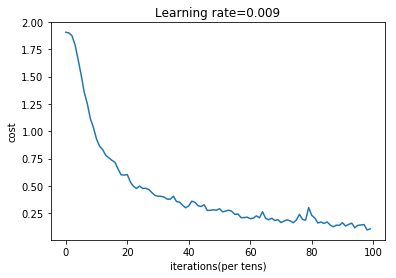

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9787037
Test Accuracy: 0.8666667


In [61]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}
 
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


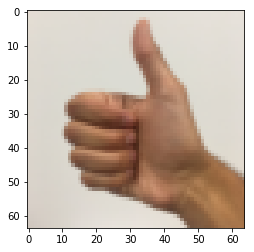

In [51]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)

In [62]:
#总结，在参数初始化函数中，W1,W2除以np.sqrt(2)作为初始参数，不然cost代价计算会有问题